## Cross Matching the Debris Disks with Andrae 2023

https://arxiv.org/pdf/2302.02611
https://zenodo.org/records/7945154

In [11]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt


In [2]:
alma = pd.read_csv("alma_debris_unique_with_gaia_safe.csv", dtype={"gaia_source_id_str": "string"})

# Reconstruct Int64 Gaia IDs safely (prevents float corruption)
alma["gaia_source_id"] = pd.to_numeric(alma["gaia_source_id_str"], errors="coerce").astype("Int64")

# Keep only Gaia-matched rows and make an int64 join key for DuckDB
alma_m = alma[alma["gaia_source_id"].notna()].copy()
alma_m["source_id"] = alma_m["gaia_source_id"].astype("int64")

## Look at Andrae 2023 file

In [3]:
ANDRAE_FILE = "table_1_catwise.csv.gz"

con = duckdb.connect()

schema = con.execute(f"""
    DESCRIBE
    SELECT *
    FROM read_csv_auto('{ANDRAE_FILE}')
    LIMIT 1
""").df()

schema

,column_name,column_type,null,key,default,extra
0,source_id,BIGINT,YES,None,None,None
1,catwise_w1,DOUBLE,YES,None,None,None
2,catwise_w2,DOUBLE,YES,None,None,None
3,in_training_sample,BOOLEAN,YES,None,None,None
4,mh_xgboost,DOUBLE,YES,None,None,None
5,teff_xgboost,DOUBLE,YES,None,None,None
6,logg_xgboost,DOUBLE,YES,None,None,None


## Match

In [4]:
con.register("alma_ids", alma_m[["source_id"]].drop_duplicates())

andrae_sub = con.execute(f"""
    SELECT
        source_id,
        mh_xgboost,
        teff_xgboost,
        logg_xgboost,
        in_training_sample
    FROM read_csv_auto('{ANDRAE_FILE}')
    JOIN alma_ids USING (source_id)
""").df()

# Merge back onto ALMA table
alma_andrae = alma_m.merge(andrae_sub, on="source_id", how="left")

alma_andrae.to_csv(
    "alma_debris_with_gaia_andrae.csv",
    index=False
)

print("Saved alma_debris_with_gaia_andrae.csv")
print("Rows with metallicity:", alma_andrae["mh_xgboost"].notna().sum())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Saved alma_debris_with_gaia_andrae.csv
Rows with metallicity: 536


In [5]:
alma_andrae["andrae_quality"] = "good"

alma_andrae.loc[
    alma_andrae["in_training_sample"] == False,
    "andrae_quality"
] = "extrapolated"

alma_andrae.loc[
    alma_andrae["in_training_sample"].isna(),
    "andrae_quality"
] = "missing"

In [7]:
alma_andrae["andrae_quality"].value_counts(dropna=False)

andrae_quality
extrapolated    488
missing         170
good             48
Name: count, dtype: int64

In [8]:
gold = alma_andrae[
    (alma_andrae["andrae_quality"] == "good") &
    (alma_andrae["gaia_match_quality"] == "good") &
    (alma_andrae["mh_xgboost"].notna())
].copy()

print("Gold sample:", len(gold))

Gold sample: 47


In [9]:
silver = alma_andrae[
    (alma_andrae["andrae_quality"] != "missing") &
    (alma_andrae["gaia_match_quality"] != "bad") &
    (alma_andrae["mh_xgboost"].notna())
].copy()

print("Silver sample:", len(silver))

Silver sample: 536


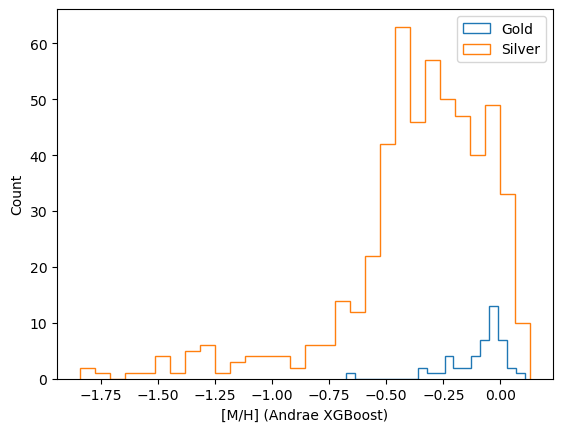

In [12]:
plt.hist(
    gold["mh_xgboost"],
    bins=20,
    histtype="step",
    label="Gold",
)

plt.hist(
    silver["mh_xgboost"],
    bins=30,
    histtype="step",
    label="Silver",
)

plt.xlabel("[M/H] (Andrae XGBoost)")
plt.ylabel("Count")
plt.legend()
plt.show()